# Introduction to spatial data with Geopandas

Lino Galiana  
2024-09-23

<div class="alert alert-info" role="alert">
<h3 class="alert-heading">Version 🇫🇷</h3>
This is the French version 🇫🇷 of that chapter,to see the English version go <a href="https://pythonds.linogaliana.fr/content/manipulation/03_geopandas_intro.html">there</a>
</div>

# 1. Introduction

## 1.1 What’s so special with spatial data ?

Previous chapters have introduced how structured data can be leveraged using the `Pandas` library. We will now explore the analysis of more complex data, namely spatial data. These datasets are more sophisticated than tabular data since they not only share the properties of tabular data (flattened data in a structure of columns and rows) but also include an additional geographical dimension. This dimension can be more or less complex depending on the nature of the data: it can be points (2D location coordinates), lines (a series of points), directional lines (the same structure as before but with a direction), polygons (a set of points), etc. This diversity of geographic objects aims to allow information systems and representations of numerous geographic objects.

From now on, we will refer to *“spatial data”* as all data that pertain to the geographical characteristics of objects (location, contours, links). The geographical characteristics of objects are described using a **coordinate system**. These allow the representation of the geographic object in a two-dimensional Euclidean space $(x,y)$. The transition from the real space (the Earth, which is a three-dimensional sphere) to the planar space is done through a **projection system**.

## 1.2 Structure of spatial data

Spatial data typically gather two types of data:

1.  **Geographical data** (or geometries): geometric objects such as points, vectors, polygons, or meshes (*raster*). Example: the shape of each municipality, the coordinates of a building, etc. ;
2.  **Attributive data** (or attributes): measurements and characteristics associated with geometric objects. Example: the population of each municipality, the number of windows and the number of floors of a building, etc.

**Spatial data are frequently processed using a geographic information system (GIS)**, which is an information system capable of storing, organizing, and presenting alphanumeric data spatially referenced by coordinates in a reference system (CRS). `Python` has functionalities allowing it to perform the same tasks as a GIS (processing spatial data, creating cartographic representations).

## 1.3 Spatial data analysis is not new

Initially used mainly for military or administrative purposes, cartographic production has been very common to represent socioeconomic information since at least the 19th century. The most well-known representation in this field is the choropleth map[1].

According to Chen et al. (2008), the first representation of this type was proposed by Charles Dupin in 1926 to represent education levels in France. The emergence of choropleth maps is indeed inseparable from the organization of power into entities considered unitary: world maps often represent color gradients based on nations, national maps based on administrative levels (regions, departments, municipalities, but also states or *landers*).

![The first choropleth map by Dupin (1826)](https://upload.wikimedia.org/wikipedia/commons/thumb/3/38/Carte_figurative_de_l%27instruction_populaire_de_la_France.jpg/800px-Carte_figurative_de_l%27instruction_populaire_de_la_France.jpg).

While the production of geographical information may have been closely tied to military use and administrative management of a territory, the digitalization of the economy has multiplied the actors concerned with collecting and making geographical data available. Thus, handling and representing spatial data is no longer the exclusive domain of geographers and geomatics engineers. Data scientists must be able to quickly explore the structure of a geographic dataset just as they would with traditional tabular datasets.

## 1.4 Where can we find French spatial data?

During our journey of discovering `Pandas`, we have already encountered some geolocated sources, notably produced by INSEE. This institution publishes numerous local statistics, such as the Filosofi data we encountered in the previous chapter. Beyond INSEE, all institutions of the public statistical system (INSEE and ministerial statistical services) publish many aggregated data sources at different geographical scales: sub-municipal level (e.g., [200m tiles](https://www.insee.fr/fr/statistiques/6215138?sommaire=6215217)), municipal level, or supra-municipal levels (administrative or study area zonings).

More generally, many French administrations outside the public statistical system disseminate geographic data on [data.gouv](https://www.data.gouv.fr/fr/). For example, we previously exploited a dataset from ADEME whose geographical dimension was the municipality.

The central player in the French public geographic data ecosystem is [IGN](https://www.ign.fr/). Well known to hiking enthusiasts for its *“Top 25”* maps, which can be found on the [geoportail](https://www.geoportail.gouv.fr/carte), IGN is also responsible for mapping the legal boundaries of French administrative entities (AdminExpress base), forests (BDForêt), roads (BDRoute), buildings (BDTopo), etc. We briefly mentioned the [`cartiflette`](https://github.com/InseeFrLab/cartiflette) library in the previous chapter, which allows flexible retrieval of administrative map bases (AdminExpress base) with `Python`; we will go further in this chapter.

The public authorities are no longer the only ones producing and disseminating spatial data. Collecting GPS coordinates has become almost automatic, and many actors collect, exploit, and even sell geospatial data on their users. These data can be very precise and rich on certain issues, such as mobility. However, it is necessary to keep in mind when wanting to extrapolate statistics built on these data that they concern users of the specific service, who may not be representative of the behaviors of the population as a whole.

## 1.5 Objectives

This chapter illustrates some central principles of data analysis through practical examples:

-   Manipulations on the attributes of datasets;
-   Geometric manipulations;
-   Management of cartographic projections;
-   Quick creation of maps (to be explored further in a later chapter).

## 1.6 Data

In this chapter, we will use the following data:

-   [Free floating bike rents (Vélib) data](https://opendata.paris.fr/explore/dataset/velib-emplacement-des-stations/download/?format=geojson&timezone=Europe/Berlin&lang=fr);
-   [French administrative design](https://geoservices.ign.fr/adminexpress) through a `Python` package named [`cartiflette`](https://github.com/InseeFrLab/cartiflette) which facilitates the retrieval of this source.

## 1.7 Preliminary installations

This tutorial requires some package installations to be reproducible

[1] Despite all its limitations, which we will revisit, the choropleth map is nonetheless informative. Knowing how to produce one quickly to grasp the main structuring facts of a dataset is particularly useful.

In [1]:
!pip install pandas fiona shapely pyproj rtree 
!pip install contextily
!pip install geopandas
!pip install topojson

To be able to run this tutorial, the following imports will be useful.

In [2]:
import geopandas as gpd
import contextily as ctx
import matplotlib.pyplot as plt


<div class="alert alert-danger" role="alert">
<h3 class="alert-heading"><i class="fa-solid fa-triangle-exclamation"></i> Warning</h3>

The `cartiflette` package is experimental and is only available on
[`Github`](https://github.com/InseeFrLab/cartogether), not on `PyPi`.
It is expected to evolve quickly and this page will be updated
when new functionalities (especially the use of `API`)
are available to further simplify the retrieval of
geographic boundaries.

</div>

To install `cartiflette`, you need to use the following commands
from a `Jupyter Notebook` (if you use the command line directly,
you can remove the `!` at the beginning of the line):

In [3]:
!pip install py7zr geopandas openpyxl tqdm s3fs
!pip install PyYAML xlrd
!pip install git+https://github.com/inseefrlab/cartiflette

# 2. From `Pandas` to `Geopandas`

The `Geopandas` package is a toolkit designed to facilitate the manipulation of spatial data. **The great strength of `Geopandas` is that it allows for the manipulation of spatial data as if it were traditional data**, because it is based on the ISO 19125 [*simple feature access*](https://en.wikipedia.org/wiki/Simple_Features) standard defined jointly by the *Open Geospatial Consortium (OGC)* and the *International Organization for Standardization (ISO)*. `Geopandas` relies on `Pandas` for handling the tabular aspect of spatial data and on [`Shapely`](https://shapely.readthedocs.io/en/stable/manual.html) and [`GDAL`](https://gdal.org/index.html) for geometric manipulations. However, just as `Pandas` allows you to use `Numpy` without knowing it, working with `Geopandas` lets you leverage `Shapely` and `GDAL` without having to deal with them directly.

Compared to a standard *DataFrame*, a `Geopandas` object includes an additional column: `geometry`. This column stores the coordinates of geographic objects (or sets of coordinates in the case of boundaries). A `Geopandas` object inherits the properties of a `Pandas` *DataFrame* but offers methods tailored to the handling of spatial data. Therefore, with `GeoPandas`, you have attributes based on the principle of *tidy* data discussed in the [previous chapter](content/manipulation/02_pandas_intro.qmd) while the associated geometry is managed consistently alongside the attributes.

Thus, with `Geopandas`, you can perform attribute manipulations as with `pandas`, but you can also manipulate the spatial dimension of the data. Specifically, you can:

-   Calculate distances and areas;
-   Aggregate zonings quickly (e.g., grouping municipalities into departments);
-   Find out which municipality a building is located in based on its geographic coordinates;
-   Recalculate coordinates in another projection system;
-   Create a map quickly and easily.

<div class="alert alert-success" role="alert">
<h3 class="alert-heading"><i class="fa-solid fa-lightbulb"></i> Tip</h3>

Manipulating data in a `Geopandas` object is significantly slower than in a traditional `DataFrame` (since `Python` has to handle geographic information during data manipulation).
When working with large datasets, it may be preferable to perform operations on the data before attaching geometry to it.

</div>

Compared to specialized software like `QGIS`, `Python` allows for the automation of data processing and visualization. In fact, `QGIS` itself uses `Python`…

## 2.1 Anatomy of a `GeoPandas` object

In summary, a `GeoPandas` object consists of the following elements:

![](https://rgeo.linogaliana.fr/slides/img/sf.png)

1.  **Attributes**: These are the values associated with each geographic level. This is the usual tabular dimension, treated similarly to a standard `Pandas` object.
2.  **Geometries**: These are numerical values interpreted to represent the geographic dimension. They allow representation in a specific reference frame (the reference system).
3.  **Reference System**: This system transforms positions on the globe (3D with an asymmetrical sphere) into a 2D plane. There are numerous systems, identifiable by an EPSG code (4326, 2154, etc.). Their manipulation is facilitated by `Geopandas`, which relies on `Shapely`, just as `Pandas` relies on `Numpy` or `Arrow`.

# 3. Reading and enriching spatial data

In the previous chapter, we discussed flat data formats such as `CSV` and newer formats like `Parquet`. These are suitable for tabular data. For geographic data, which store information across multiple dimensions (attributes and geometry), there are specialized formats.

## 3.1 Shapefile (`.shp`) and geopackage (`.gpkg`) formats

The historical format for storing spatial data is the [shapefile](https://en.wikipedia.org/wiki/Shapefile). It is a proprietary format developed by ESRI that has become a de facto standard. In this format, data

## 3.2 GeoJSON and TopoJSON

The development of a format to rival the hegemony of the shapefile is intrinsically linked to the emergence of web technologies in the cartography sector. These web technologies rely on Javascript and adhere to the JSON format standards.

The GeoJSON format stores both attributes and geometries in a single file. This makes it quite convenient to use and it has become the preferred format among web developers. However, storing all information in one file can make it quite large if the geometries are very detailed, though it is still less bulky than the shapefile. `GeoPandas` is well-equipped to read files in the GeoJSON format, and data-sharing platforms like `data.gouv` favor this format over the shapefile.

To reduce file size, the TopoJSON format has recently emerged. It is built on the same principles as GeoJSON but reduces the volume of stored geometric data by simplifying it, retaining only arcs and directions between points. As this format is new, it is not yet well-integrated into the `Python` ecosystem.

## 3.3 Other data formats

The ecosystem of geographic data formats is much more fragmented than that of structured data. Each format offers advantages that make it suitable for certain types of data but has limitations that prevent it from becoming a standard for other types of data.

For example, GPS data extracted from various applications (e.g., `Strava`) are stored in the GPX format. This format is particularly well-suited for geolocated traces with altitude. However, it is not the most appropriate format for storing directional lines, which are essential for routing applications.

The shapefile and geojson formats are sufficiently versatile to adapt to various types of geographic data, even if they are not the optimal format for every type of data. Within this generalist class of formats, the Geoparquet might be the next trending format. As its name suggests, it is an extension of the Parquet format to geographic data. This format is not yet mature but is worth keeping an eye on, as the large user base of the Parquet ecosystem could lead to a rapid shift if a stable implementation of Geoparquet emerges.

This [page](https://si.ecrins-parcnational.com/blog/2020-02-geojson-shapefile-geopackage.html) provides a more detailed comparison of the main geographic data formats. The help section of [`Geopandas`](https://geopandas.org/io.html) offers code snippets for various situations.

## 3.4 An exercise to discover spatial data

The goal of this exercise is to illustrate the similarity between `GeoPandas` objects and the `Pandas` objects we previously explored.

We will directly import the `AdminExpress` data (official boundaries of municipalities produced by IGN) using `cartiflette`:

<div class="alert alert-success" role="alert">
<h3 class="alert-heading"><i class="fa-solid fa-pencil"></i> Exercise 1: Discovering spatial objects</h3>

First, we will retrieve geographic data using the `cartiflette` package and its `carti_download` function.

1.  Use the code below to download municipal data (IGN’s `Admin Express` product) for the departments of the inner suburbs (75, 92, 93, and 94) in a simplified manner using the `cartiflette` package:

``` python
# | echo: true
# | output: false
from cartiflette import carti_download

communes_borders = carti_download(
    crs=4326,
    values=["75", "92", "93", "94"],
    borders="COMMUNE",
    vectorfile_format="geojson",
    filter_by="DEPARTEMENT",
    source="EXPRESS-COG-CARTO-TERRITOIRE",
    year=2022,
)
```

1.  Look at the first few rows of the data. Identify the difference from a standard dataframe.

2.  Display the projection system (attribute `crs`) of `communes_borders`. This controls the transformation of the three-dimensional terrestrial space into a flat surface. Use `to_crs` to transform the data into Lambert 93, the official system (EPSG code 2154).

3.  Display the municipalities of Hauts de Seine (department 92) and use the `plot` method.

4.  Keep only Paris and plot the borders on a map: what is the problem for an analysis of intramural Paris?

You will quickly notice the problem. We do not have the boundaries of Parisian districts, which greatly impoverishes the map of Paris.

1.  This time, use the argument `borders="COMMUNE_ARRONDISSEMENT"` to obtain a consolidated map with the municipalities and districts in large cities. Convert to Lambert 93.

</div>

The visualization provided in the question shows that our `GeoDataFrame` includes a `geometry` column containing the necessary information to determine the municipal boundaries.

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

The data is in WGS84, we reproject it to Lambert 93

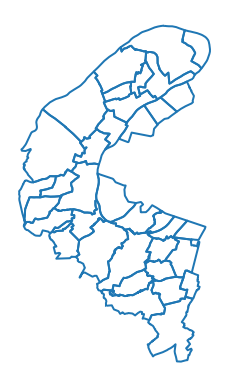

In question 5, the issue for Paris is easily noticeable: the boundaries of the arrondissements are missing. This significantly reduces the detail of the map of Paris.

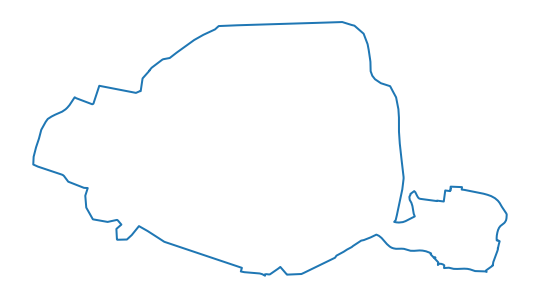

At the end of question 6, we obtain the expected map for inner Paris:

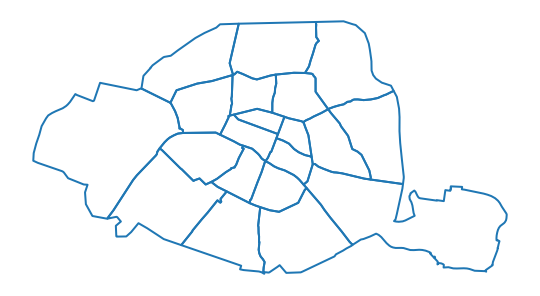

# 4. The coordinate reference system (CRS)

## 4.1 Principle

Spatial data is richer than traditional data because it usually includes additional elements to place objects in a Cartesian space. This additional dimension can be simple (a point has two additional pieces of information: $x$ and $y$) or quite complex (polygons, lines with direction, etc.).

Cartographic analysis, therefore, borrows concepts from geometry to represent objects in space. **Projections** are at the heart of managing spatial data. These projections consist of transforming a position in terrestrial space into a position on a plane. This is a projection operation from a three-dimensional space into a two-dimensional space. This [post](https://www.earthdatascience.org/courses/earth-analytics/spatial-data-r/geographic-vs-projected-coordinate-reference-systems-UTM/) offers rich elements on the subject, including the following image that clearly shows the principle of a projection:

<figure>
<img src="https://www.earthdatascience.org/images/courses/earth-analytics/spatial-data/spatial-projection-transformations-crs.png" alt="Different types of projection" />
<figcaption aria-hidden="true">Different types of projection</figcaption>
</figure>

This operation is not neutral. One of the consequences of the [remarkable theorem of Gauss](https://en.wikipedia.org/wiki/Theorema_egregium) is that the surface of the Earth cannot be mapped without distortion. A projection cannot simultaneously keep distances and angles intact (i.e., positions). Thus, there is no universally better projection, which opens the door to the coexistence of many different projections, designed for different tasks. A poor projection system can distort visual appreciation and also cause errors in calculations on the spatial dimension.

**Projection systems are subject to international standards and are often designated by so-called EPSG codes**. This [site](https://epsg.io/) is a good reference. The most common for French users are as follows (more info [here](https://geodesie.ign.fr/contenu/fichiers/documentation/SRCfrance.pdf)):

-   `2154`: Lambert 93 projection system. This is the official projection system. Most data published by the administration for the metropolis is available in this projection system.
-   `27572`: Lambert II extended. This is the former official projection system. Older spatial data may be in this format.
-   `4326`: WGS 84 or pseudo-Mercator system or *Web Mercator*. This is not actually a projection system but a coordinate system (longitude/latitude) that simply allows angular positioning on the ellipsoid. It is used for GPS data. This is the most common system, especially when working with web map backgrounds.

## 4.2 The Mercator System

As mentioned earlier, one of the most well-known projections is the *Web Mercator* projection, also known as WGS84 (EPSG code 4326). This projection preserves angles, which means it distorts distances. It was originally designed to represent the Northern Hemisphere. The farther you move away from it, the more distances are distorted. This leads to well-known distortions (Greenland being oversized, Africa reduced in size, Antarctica being immense, etc.). However, the Mercator projection keeps positions intact. This property explains its use in GPS systems and navigation map backgrounds like *Google Maps*. It is a projection primarily designed for navigation, not for representing socio-economic information on Earth. This projection is inseparable from the great explorations of the Renaissance, as highlighted by [this Twitter thread](https://x.com/JulesGrandin/status/1765668642094514447) by Jules Grandin.

<figure>
<img src="https://minio.lab.sspcloud.fr/lgaliana/generative-art/pythonds/truesize.png" alt="Example of country re-projection from the site thetruesize.com" />
<figcaption aria-hidden="true"><em>Example of country re-projection from the site <a href="https://thetruesize.com/">thetruesize.com</a></em></figcaption>
</figure>

<figure id="fig-mercator-funny">
<img src="https://rgeo.linogaliana.fr/exercises/img/mercator.jpg" />
<figcaption>Figure 4.1: “Don’t trust the Mercator projection” on <code>Reddit</code></figcaption>
</figure>

To go further, the following interactive map, created by Nicolas Lambert and derived from this [*Observable notebook*](https://observablehq.com/@neocartocnrs/impact-of-projections-on-areas), illustrates the distorting effect of the Mercator projection, among others, on our perception of country sizes.

There are actually many possible representations of the world, some more intricate than others. Projections are numerous, and some can have [surprising shapes](https://imgs.xkcd.com/comics/map_projections.png). For example, the [Spilhaus projection](https://storymaps.arcgis.com/stories/756bcae18d304a1eac140f19f4d5cb3d) proposes centering the view on the oceans rather than land. That’s why it is sometimes referred to as the world as seen by fish.

<div class="alert alert-success" role="alert">
<h3 class="alert-heading"><i class="fa-solid fa-lightbulb"></i> Tip for France</h3>

For France, in the WGS84 system (4326):

-   Longitude ($x$) revolves around 0° (from -5.2 to +9.6 to be precise)
-   Latitude ($y$) around 45 (between +41.3 and +51.1)

In the Lambert 93 system (2154):

-   Coordinates $x$: between 100,000 and 1,300,000
-   Latitude ($y$): between 6,000,000 and 7,200,000

[More details](https://medium.com/@_FrancoisM/introduction-%C3%A0-la-manipulation-de-donn%C3%A9es-cartographiques-23b4e38d8f0f)

</div>

## 4.3 Handling with `GeoPandas`

Regarding the management of projections with `GeoPandas`, the [official documentation](https://geopandas.org/projections.html) is very well done. It provides the following warning that is good to keep in mind:

> Be aware that most of the time you don’t have to set a projection. Data loaded from a reputable source (using the geopandas.read_file() command) should always include projection information. You can see an object’s current CRS through the GeoSeries.crs attribute.
>
> From time to time, however, you may get data that does not include a projection. In this situation, you have to set the CRS so geopandas knows how to interpret the coordinates.

<figure>
<img src="https://imgs.xkcd.com/comics/bad_map_projection_south_america.png" alt="Image borrowed from XKCD https://xkcd.com/2256/ which can also be found on https://blog.chrislansdown.com/2020/01/17/a-great-map-projection-joke/" />
<figcaption aria-hidden="true"><em>Image borrowed from XKCD <a href="https://xkcd.com/2256/" class="uri">https://xkcd.com/2256/</a> which can also be found on <a href="https://blog.chrislansdown.com/2020/01/17/a-great-map-projection-joke/" class="uri">https://blog.chrislansdown.com/2020/01/17/a-great-map-projection-joke/</a></em></figcaption>
</figure>

The two main methods for defining the projection system used are:

-   **`df.set_crs`**: This command is used to specify what projection system is used, i.e., how the coordinates *(x,y)* are related to the Earth’s surface. **This command should not be used to transform the coordinate system, only to define it**.
-   **`df.to_crs`**: **This command is used to project the points of a geometry into another, i.e., to recalculate the coordinates according to another projection system**.

In the specific case of producing a map with an OpenStreetMaps background or a dynamic leaflet map, it is necessary to de-project the data (for example from Lambert-93) to land in the unprojected WGS 84 system (code EPSG 4326). This site [dedicated to geographic projections](https://epsg.io/) can be useful for finding the projection system of a file where it is not indicated.

The next exercise will help convince you of the importance of delegating as much of the projection system management as possible to `GeoPandas`. The issue is not only about the relevance of the representation of geographic objects on the map. Indeed, all geometric operations (area calculations, distance, etc.) can be affected by the choices made regarding the projection system.

## 4.4 Exercise to understand how important a projection system can be

Here is some code using `cartiflette` again to retrieve French borders (divided by region):

In [12]:
from cartiflette import carti_download

france = carti_download(
    values=["France"],
    crs=4326,
    borders="REGION",
    vectorfile_format="geojson",
    simplification=50,
    filter_by="FRANCE_ENTIERE",
    source="EXPRESS-COG-CARTO-TERRITOIRE",
    year=2022,
)
france = france.loc[france["INSEE_REG"] > 10]


<div class="alert alert-success" role="alert">
<h3 class="alert-heading"><i class="fa-solid fa-pencil"></i> Exercise 2: Projections, representations, and approximations</h3>

1.  Experiment with representing the borders of France using several projections:

-   Mercator WGS84 (EPSG: 4326)
-   Healpix projection (`+proj=healpix +lon_0=0 +a=1`)
-   Projection for Tahiti (EPSG: 3304)
-   Albers projection for the United States (EPSG: 5070)

1.  Calculate the area in $km^2$ of the French regions in the following two projection systems:
    World Mercator WGS84 (EPSG: 3395) and Lambert 93 (EPSG: 2154). Calculate the difference in $km^2$ for each region.

</div>

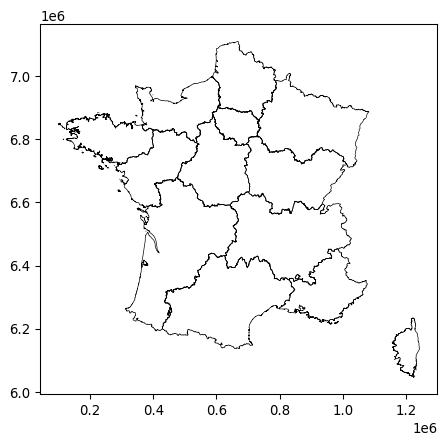

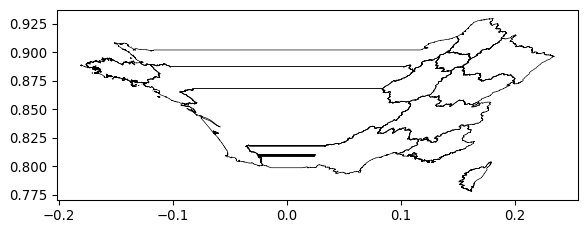

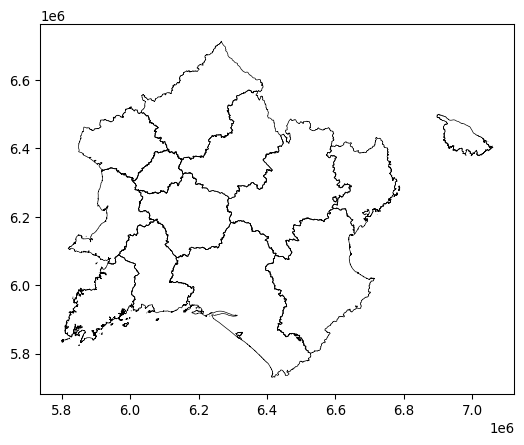

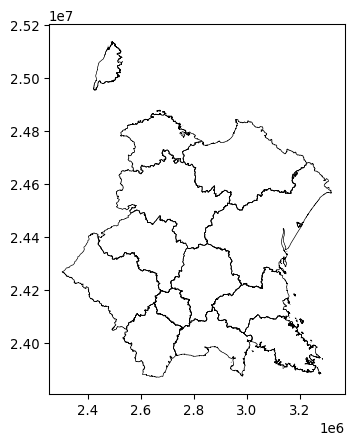

With question 1 illustrating some pathological cases,
we understand that projections have a distorting effect
which is clearly visible when we represent them side by side in the form of maps:

However, the problem is not just visual; it is also numerical. Geometric calculations lead to quite notable differences depending on the reference system used.

We can represent these approximations on a map[1] to get an idea of the regions where the measurement error is the greatest (subject of question 2).

[1] This map is not too neat; it’s normal. We will see how to make beautiful maps later.

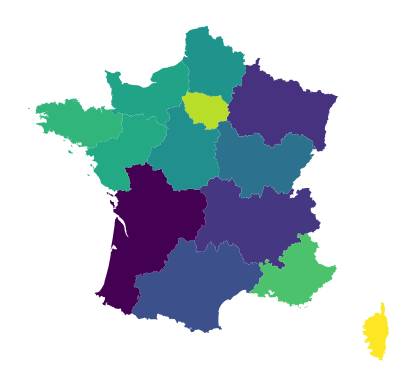

This type of measurement error is normal at the scale of the French territory.
Projections inherited from Mercator distort distances,
especially when approaching the equator or the poles.

Therefore, it is always necessary to
reproject the data into the Lambert 93 system (the
official system for mainland France) before performing geometric calculations.

# 5. Import and explore spatial datasets

Often, the communal division serves only as a background for maps, providing context and reference points. Generally, it is used to contextualize another dataset.

To illustrate this approach, we will use the data on the locations and capacities of Vélib stations, available on the [open data site of the city of Paris](https://opendata.paris.fr/explore/dataset/velib-emplacement-des-stations/table/), and directly queryable via the URL <https://opendata.paris.fr/explore/dataset/velib-emplacement-des-stations/download/?format=geojson&timezone=Europe/Berlin&lang=fr>. This dataset will help us illustrate some classic issues in spatial data analysis.

In [19]:
velib_data = "https://opendata.paris.fr/explore/dataset/velib-emplacement-des-stations/download/?format=geojson&timezone=Europe/Berlin&lang=fr"
stations = gpd.read_file(velib_data)
stations.head(2)


Skipping field coordonnees_geo: unsupported OGR type: 3

## 5.1 Locate data on a map

The first step, before thoroughly exploring the data, is to display it on a contextual map to ensure the geographic coverage of the data. In our case, this will give us an intuition about the locations of the stations, particularly their uneven density in the Parisian urban space.

## 5.2 Application

In the next exercise, we propose to quickly create a map with three layers:

-   The locations of stations as points;
-   The borders of communes and arrondissements for context;
-   The borders of departments with wider lines for additional context.

We will delve deeper into cartographic work in the next chapter. However, being able to quickly position your data on a map is always useful in exploratory work.

Before the exercise, use the following function from the `cartiflette` package to retrieve the base map of the departments of the inner suburbs:

In [20]:
idf = carti_download(
    values=["11"],
    crs=4326,
    borders="DEPARTEMENT",
    vectorfile_format="geojson",
    filter_by="REGION",
    source="EXPRESS-COG-CARTO-TERRITOIRE",
    year=2022,
)

petite_couronne_departements = idf.loc[
    idf["INSEE_DEP"].isin(["75", "92", "93", "94"])
].to_crs(2154)


<div class="alert alert-success" role="alert">
<h3 class="alert-heading"><i class="fa-solid fa-pencil"></i> Exercise 3: Import and explore the Velib data</h3>

Let’s start by retrieving the data needed to produce this map.

1.  Check the geographic projection of `station` (attribute `crs`). If it is different from the commune data, reproject the latter to the same projection system as the Velib stations.
2.  Keep only the top 50 stations (variable `capacity`).

We can now build the map sequentially using the `plot` method, with the help of [this documentation](https://geopandas.org/en/stable/docs/user_guide/mapping.html#maps-with-layers).

1.  First, use `boundary.plot` to represent the base layer of commune and arrondissement boundaries:

    -   Use the options `edgecolor = "black"` and `linewidth = 0.5`
    -   Name this object `base`

2.  Add the layer of departments with the options `edgecolor = "blue"` and `linewidth = 0.7`.

3.  Add the positions of the stations and adjust the size according to the `capacity` variable. The aesthetics of the obtained points can be controlled with the options `color = "red"` and `alpha = 0.4`.

4.  Remove the axes and add a title with the options below:

``` python
base.set_axis_off()
base.set_title("The 50 main Velib stations")
```

1.  Following the model below, use the `contextily` package to add a contextual OpenStreetMap base map:

``` python
import contextily as ctx

ax = ...
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)
```

⚠️ `contextily` expects data in the Pseudo Mercator representation system ([EPSG: 3857](https://epsg.io/3857)), so it will be necessary to reproject your data before creating the map.

</div>

The base layer obtained after question 3

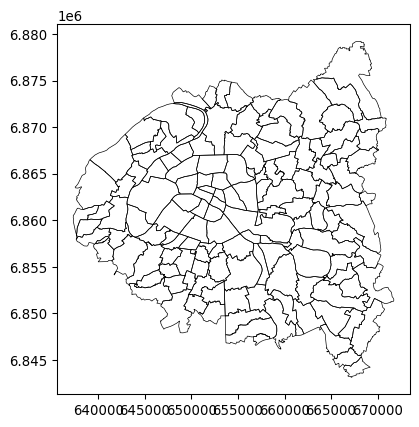

Then by adding the departmental boundaries (question 4).

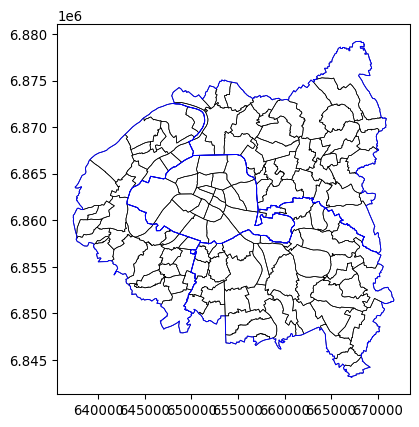

Then the stations (question 5).

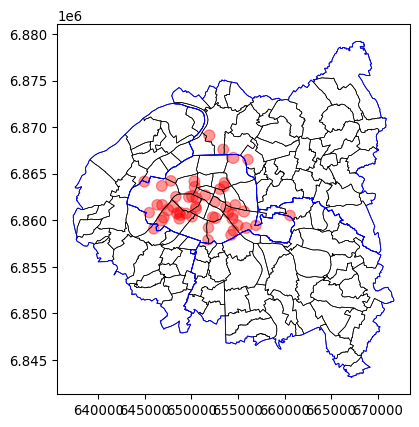

Next, if we remove the axes (question 6), we get:

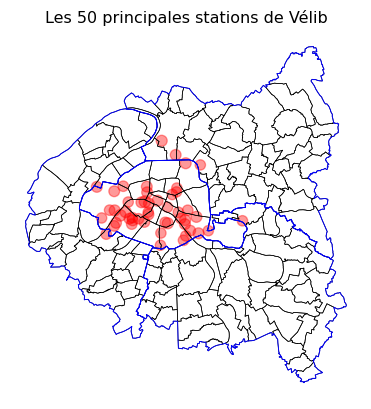

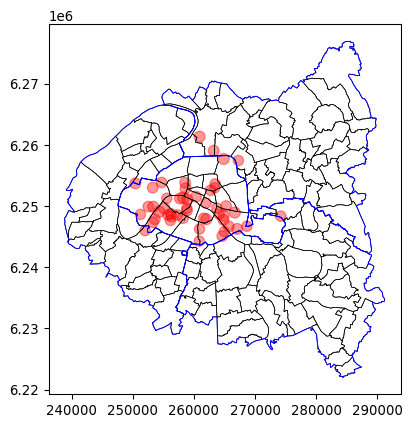

The map speaks for itself. However, for those less familiar with Parisian geography, it could be made even clearer with the addition of a contextual background map *openstreetmap*. In fine, this results in the following map:

<Axes: title={'center': 'Les 50 principales stations de Vélib'}>

<Figure size 672x480 with 0 Axes>

## 5.3 Geometric operations

In addition to simplified graphical representation, the main advantage of using `GeoPandas` is the availability of efficient methods for manipulating spatial dimensions. Many of these methods come from the package [`Shapely`](https://shapely.readthedocs.io/en/latest/manual.html#general-attributes-and-methods).

We have already seen the `to_crs` method for reprojecting data vectorized without worrying. We have also mentioned the `area` method to calculate areas. There are many such methods, and the goal of this chapter is not to be exhaustive but to serve as a general introduction to delve deeper later. Among the most useful methods, we can mention `centroid`, which, as its name suggests, finds the centroid of each polygon, thus transforming surface data into point data. For example, to roughly represent the centers of villages in Haute-Garonne (31), after downloading the appropriate base map, we will do the following:

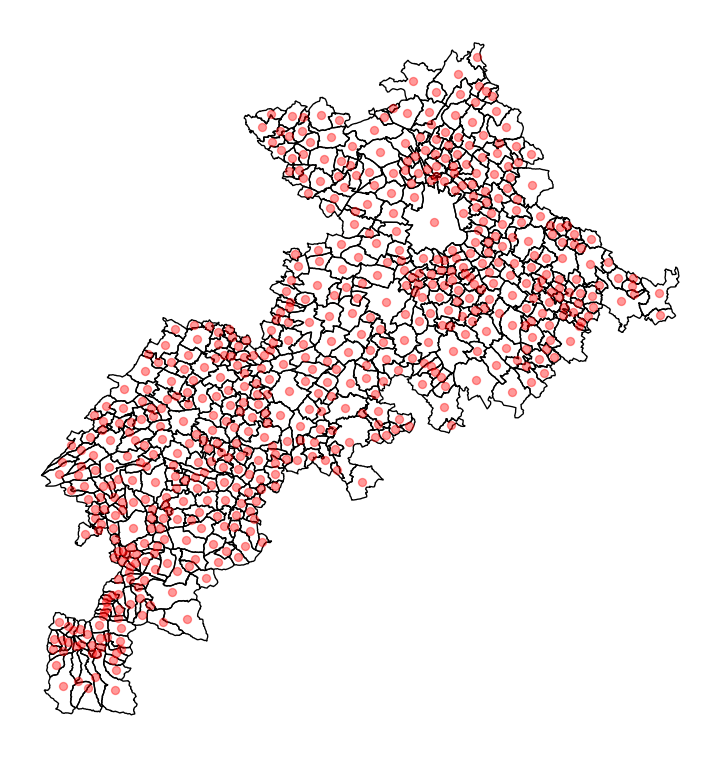

In [29]:
from cartiflette import carti_download

communes_31 = carti_download(
    values=["31"],
    crs=4326,
    borders="COMMUNE",
    vectorfile_format="geojson",
    filter_by="DEPARTEMENT",
    source="EXPRESS-COG-CARTO-TERRITOIRE",
    year=2022,
)

# on reprojete en 3857 pour le fond de carte
communes_31 = communes_31.to_crs(3857)

# on calcule le centroide
dep_31 = communes_31.copy()
communes_31["geometry"] = communes_31["geometry"].centroid

ax = communes_31.plot(figsize=(10, 10), color="red", alpha=0.4, zorder=2)
dep_31.to_crs(3857).plot(
    ax=ax, zorder=1, edgecolor="black", facecolor="none", color=None
)
# ctx.add_basemap(ax, source = ctx.providers.Stamen.Toner)
ax.set_axis_off()
ax


Therefore, with `Geopandas`, the entire `Pandas` grammar can be used to process the attribute dimension of the data while the geographic dimension can be manipulated with appropriate methods.

# 6. Enrichments through the spatial dimension: spatial joins

## 6.1 Principle

The previous map already illustrates the power of cartographic representation. With just a few lines of code and minimal operations on our data, we already gain a better understanding of the phenomenon we wish to observe. Specifically, we clearly detect a center-periphery structure in our data, which is not surprising but reassuring to find at first glance.

We also notice that the most used stations, outside of the hypercenter of Paris, are generally located on major roads or near parks. Again, nothing surprising, but it is reassuring to see this in our data.

Now, we can explore the structure of our dataset more thoroughly. However, if we look at it, we notice that we have limited information in the raw dataset.

In [30]:
stations.head(2)


In the previous chapter, we presented how associating datasets through a common dimension can enhance their value. In that case, it involved matching data based on common information in both datasets.

Now we have an additional implicit information in our two datasets: the geographical dimension. Spatial join refers to the association of datasets based on the geographical dimension. There are many different types of spatial joins: finding points within a polygon, finding intersections between multiple areas, linking a point to its nearest neighbor in another source, etc.

## 6.2 Example: locating stations in their neighborhood

In this exercise, we will assume that:

-   The locations of the `velib` stations are stored in a dataframe named `stations`.
-   The administrative data is in a dataframe named `petite_couronne`.

<div class="alert alert-success" role="alert">
<h3 class="alert-heading"><i class="fa-solid fa-pencil"></i> Exercise 4: Associate Stations with Their Corresponding Communes and Arrondissements</h3>

1.  Perform a spatial join to enrich the station data by adding information from `petite_couronne`. Call this object `stations_info`.
2.  Count the number of stations and the median size of the stations by arrondissement.
3.  Create the objects `stations_19e` and `arrondissement_19e` to store, respectively, the stations belonging to the 19th arrondissement and the boundaries of the arrondissement.
4.  Count the number of velib stations and the number of velib spots by arrondissement or commune. Represent each of these pieces of information on a map.
5.  Represent the map of stations in the 19th arrondissement with the following code:

``` python
base = petite_couronne.loc[petite_couronne["INSEE_DEP"] == "75"].boundary.plot(
    edgecolor="k", linewidth=0.5
)
arrondissement_19e.boundary.plot(ax=base, edgecolor="red", linewidth=0.9)
stations_19.plot(ax=base, color="red", alpha=0.4)
base.set_axis_off()
base.set_title("Les stations Vélib du 19e arrondissement")
base
```

Following the previous examples, only represent the 19th arrondissement and add an openstreetmap background to better locate the stations.

1.  Represent the same information but in density (divide by the surface area of the arrondissement or commune in km²).

</div>

After the spatial join, the dataset presents the following structure:

2 rows × 31 columns

We can therefore calculate statistics by district, just as we would with a `Pandas DataFrame` (question 2):

83 rows × 3 columns

However, maps will probably be more illustrative. To begin with question 3, we can represent the stations of the 19th arrondissement, first within the whole of Paris.

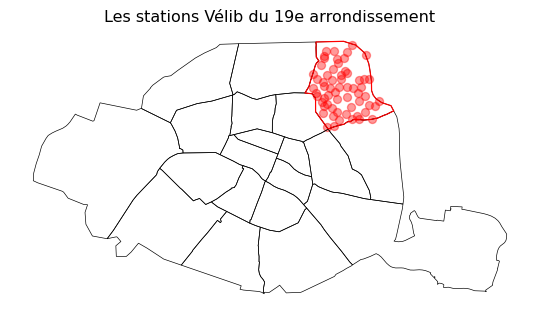

We can then zoom in on this arrondissement and create a map with a more detailed background:

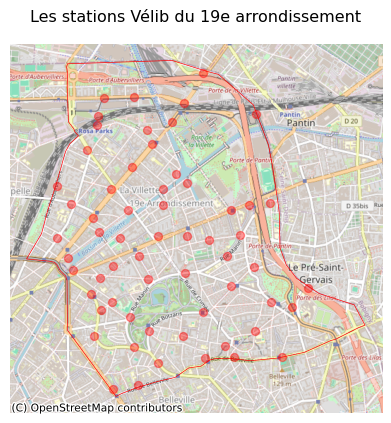

Our map after question 5 looks like the following one

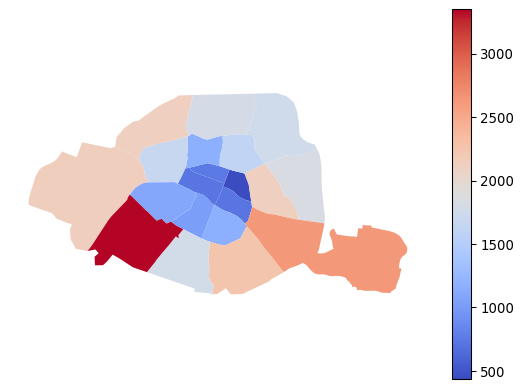

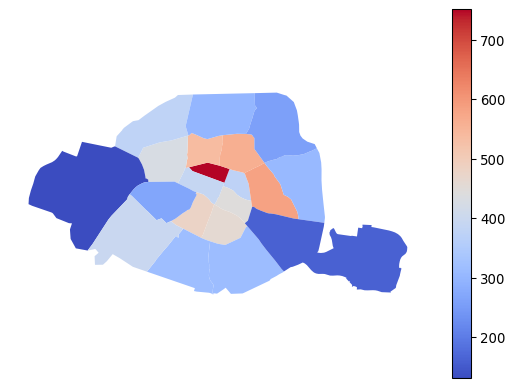

With this map, based on color gradients (choropleth map), the reader falls victim to a classic illusion. The most visible arrondissements on the map are the largest ones. It is logical that these areas are also better equipped with Vélib stations. Although the availability of Vélib stations is likely more related to population density and infrastructure, the size effect is likely the most visible phenomenon on our map, even though it might not be the primary factor in reality.

If we instead represent the capacity in terms of density, to account for the varying sizes of the arrondissements, the conclusions are reversed and better align with the expectations of a center-periphery model. The central arrondissements are better equipped. If we made a map with proportional circles rather than a choropleth map, this would be even more visible; however, cartography is not the focus of this chapter.

<Axes: >

## 6.3 Additional exercise

The previous exercises allowed for familiarization with the processing of spatial data. However, it is often necessary to juggle more complex geometric dimensions. This can include, for example, changing territorial scales in the data or introducing merges/dissolutions of geometries.

We will illustrate this with an additional exercise that demonstrates how to work with data in urban economic models where we assume movement to the nearest point ([Hotelling’s model](https://en.wikipedia.org/wiki/Hotelling%27s_law)).

Let’s imagine that each Vélib user moves exclusively to the nearest station (assuming there is never a shortage or overcapacity). What is the map of Vélib coverage? To answer this type of question, we frequently use the [Voronoi tessellation](https://en.wikipedia.org/wiki/Voronoi_diagram), a classic operation for transforming points into polygons.

The following exercise allows for familiarization with the construction of Voronoi[1].

<div class="alert alert-success" role="alert">
<h3 class="alert-heading"><i class="fa-solid fa-pencil"></i> Exercise 5 (optional): Coverage map of the stations</h3>

This exercise is more complex because it involves going back to `Shapely`, a lower-level library than `GeoPandas`.

This exercise is left open-ended. A possible source of inspiration is this discussion on [StackExchange](https://gis.stackexchange.com/questions/337561/making-polygon-for-every-point-in-set-using-voronoi-diagram).

The objective is to make two coverage maps: one at the level of the petite couronne and the other only within Paris intramuros.

</div>

The first coverage map, at the agglomeration level, shows the higher density of Velib stations in central Paris:

[1] In [this working paper](https://www.insee.fr/en/statistiques/4925202) on mobile phone data, it is shown that this approach is not without bias in phenomena where the spatial proximity hypothesis is overly simplistic.

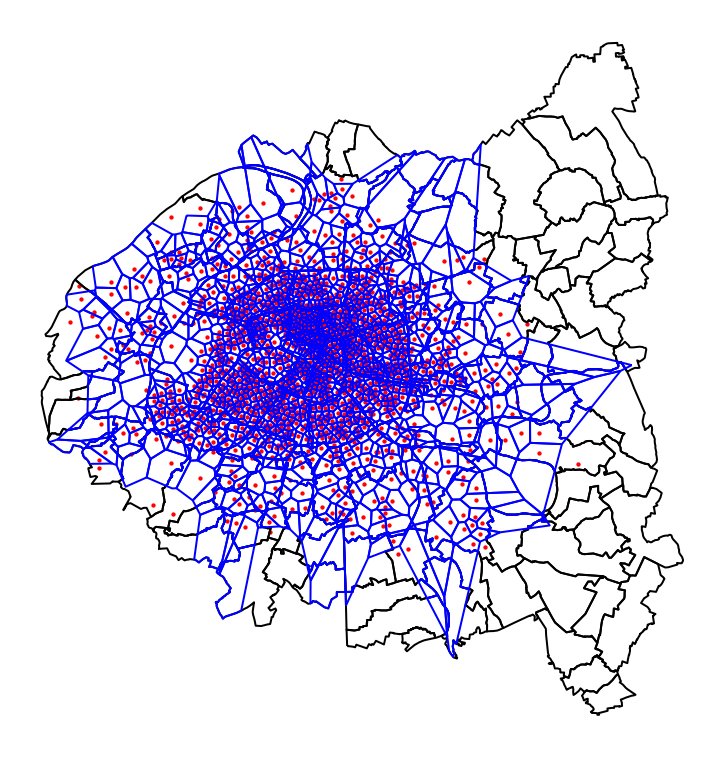

If we zoom in on Paris intramuros, we also see heterogeneity in coverage.
There is less heterogeneity in coverage areas since the density is high, but we still notice divergences between certain areas.

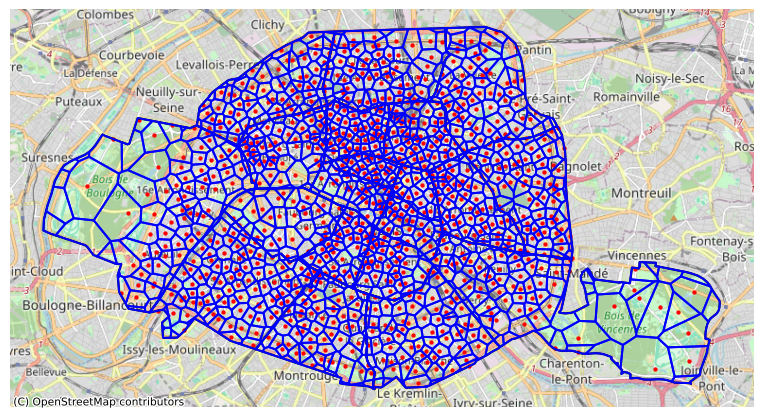

Chen, Chun-houh, Wolfgang Härdle, Antony Unwin, and Michael Friendly. 2008. “A Brief History of Data Visualization.” *Handbook of Data Visualization*, 15–56.